# Example: process delay scan

In [1]:
import karabo_data as kd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import multiprocessing
from tqdm.auto import tqdm
from time import strftime
import os
import dssc_process as dp

kd.__version__

'0.6.2'

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (11, 7)

In [3]:
# make sure subfolders exist
for f in ['tmp', 'images', 'processed_runs']:
    if not os.path.isdir(f):
        os.mkdir(f)

# setup processing and index non-DSSC data

In [24]:
%%time

# basic run information
proposal = 2212
run_nr = 235
is_dark = False

# DSSC frame names - make sure, "dark" is included in names for frames without FEL
framepattern = ['pumped', 'unpumped']

# scan settings (set scan_variable to None for static data)
stepsize = .03  # set to None to disable rounding - might give poor statistics on some values

# scan_variable = ('SCS_ILH_LAS/PHASESHIFTER/DOOCS', 'actualPosition.value')
scan_variable = ('SCS_ILH_LAS/DOOCS/PP800_PHASESHIFTER', 'actualPosition.value')
# scan_variable = ('SA3_XTD10_MONO/MDL/PHOTON_ENERGY', 'actualEnergy.value')
# scan_variable = ('SCS_ILH_LAS/DOOCS/PPL_OPT_DELAY', 'actualPosition.value')

scan_variable = None if is_dark else scan_variable

# index non-DSSC data
run = dp.load_run_selective(proposal, run_nr, exclude='DSSC')

CPU times: user 561 ms, sys: 359 ms, total: 920 ms
Wall time: 11.1 s


# prepare scan variable and write to file for subprocesses

In [25]:
scanfile = './tmp/scan.h5'
maskfile = './tmp/mask.h5'
# maskfile = None

for fname in [scanfile, maskfile]:
    if fname is not None:
        if os.path.isfile(fname):
            os.remove(fname)

dssc_info = dp.load_dssc_info(proposal, run_nr)
fpt = dssc_info['frames_per_train']
print('DSSC frames per train:', fpt)

scan = dp.load_scan_variable(run, scan_variable, stepsize)
scan.to_netcdf(scanfile, group='data', mode='w')

DSSC frames per train: 20


## optional: discard groups with low number of trains
This is usually not necessary when stepsize is set correctly

In [6]:
n_min = 10

grouped = scan.groupby(scan)

for val, grp in grouped:
    if len(grp) < 10:
        scan.loc[{'trainId': grp.trainId.values}] = np.nan

scan = scan.dropna('trainId')
scan.to_netcdf(scanfile, group='data', mode='w')

## mask individual pulses based on XGM thresholding
It is possible to pass a 2d binary mask (DataArray dimensions 'trainId' and 'pulse) to (de)select trains and/or pulses.
Broadcasting is supported, so passing just a 1d DataArray with one of the two dimensions is also possible.
Care has to be taken to match the frame numbers of the DSSC data - especially when intermediate dark frames are recorded, the number of XGM pulse numbers do not necessarily match the DSSC frame numbers.
This functionality may also be used to limit the number of DSSC frames processed, e.g., when more frames than FEL pulses were recorded (take care that dark runs (i.e., possibly without any XGM data) still get a correct mask in that case!).

The following example selects based on XGM threshold, but you can of course build your own selection mask based on any other information as well. Just save the final xarray.DataArray to "maskfile" as shown.

In [36]:
xgm_min = 0
xgm_max = np.inf

if not is_dark:
    xgm = dp.load_xgm(run, print_info=True)
    xgm_frame_coords = dp.calc_xgm_frame_indices(xgm.shape[1], framepattern)
    xgm['pulse'] = xgm_frame_coords
    
if maskfile is not None:
    # default mask - all pulses and trains included
    pulsemask = xr.DataArray(np.ones([len(run.train_ids), fpt], dtype=bool),
                             dims=['trainId', 'pulse'],
                             coords={'trainId': run.train_ids, 'pulse': range(fpt)})

    if not is_dark:
        n_frames_dark = len([p for p in framepattern if 'dark' in p])
        valid = (xgm > xgm_min) * (xgm < xgm_max)
        pulsemask = valid.combine_first(pulsemask).astype(bool)
        nrejected = int(valid.size - valid.sum())
        percent_rejected = 100 * nrejected / valid.size
        print(f'rejecting {nrejected} out of {valid.size} pulses ({percent_rejected:.1f}%) due to xgm threshold')
    pulsemask.to_netcdf(maskfile, group='data', mode='w')

SASE3 bunches per train: 20
rejecting 249 out of 180180 pulses (0.1%) due to xgm threshold


## plot XGM and threshold

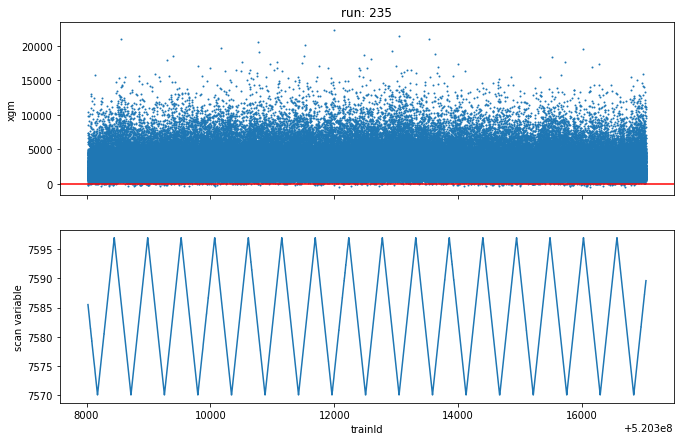

In [37]:
fig, [ax1, ax2] = plt.subplots(nrows=2, sharex=True)

# ax1.plot(scan.xgm.mean('dim_0'), label='pumped')
ax1.plot(xgm.trainId, xgm, 'o', c='C0', ms=1)
ax1.set_ylabel('xgm')
if maskfile is not None:
    ax1.axhline(xgm_min, c='r')
    ax1.axhline(xgm_max, c='r')

ax2.plot(scan.trainId, scan)
ax2.set_ylabel('scan variable')
ax2.set_xlabel('trainId')

ax1.set_title(f'run: {run_nr}')

tstamp = strftime('%y%m%d_%H%M')
# fig.savefig(f'images/run{run_nr}_scan_{tstamp}.png', dpi=200)

## plot number of trains per step

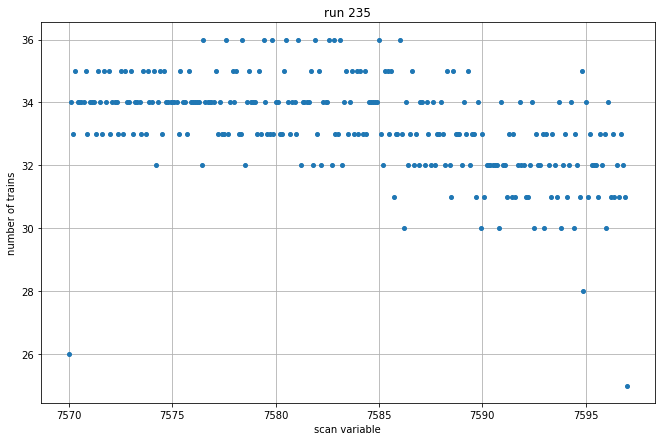

In [30]:
counts = xr.DataArray(np.ones(len(scan)),
                      dims=['scan_variable'],
                      coords={'scan_variable': scan.values},
                      name='counts')

counts = counts.groupby('scan_variable').sum()

fig, ax = plt.subplots()
ax.plot(counts.scan_variable, counts, 'o', ms=4)
ax.set_xlabel('scan variable')
ax.set_ylabel('number of trains')
ax.set_title(f'run {run_nr}')
ax.grid(True)
# plt.tight_layout()

## create joblist for multiprocessing
This is a conservative estimate for the maximum number of trains to process simultaneously without using more than "max_GB" gigabytes of memory. Caps out at 512 trains per chunk, as there doesn't seem to be any performance benefit beyond that.

In [38]:
max_GB = 400

# max_GB / (8byte * 16modules * 128px * 512px * N_pulses)
chunksize = int(max_GB * 128 // fpt)
chunksize = min(512, chunksize)  # more than 512 trains doesn't seem to give any performance benefit
print('processing', chunksize, 'trains per chunk')

processing 512 trains per chunk


In [39]:
jobs = []
for m in range(16):
    jobs.append(dict(
        proposal=proposal,
        run_nr=run_nr,
        module=m,
        chunksize=chunksize,
        scanfile=scanfile,
        framepattern=framepattern,
        maskfile=None if is_dark else maskfile,
    ))

# create multiprocessing pool and execute

In [40]:
%%time

print(f'start time:', strftime('%X'))

with multiprocessing.Pool(16) as pool:
    module_data = pool.map(dp.process_dssc_module, jobs)
    
print('finished:', strftime('%X'))

module_data = xr.concat(module_data, dim='module')
module_data = module_data.dropna('scan_variable')
module_data['run'] = run_nr

start time: 14:22:16


100%|██████████| 18/18 [04:13<00:00, 12.42s/it]

finished: 14:26:43
CPU times: user 4.77 s, sys: 8.48 s, total: 13.3 s
Wall time: 4min 32s


# merge processed data with scan variable and normalization data
If trains/ pulses were filtered, this is a good place to add additional data that has to be filtered in the same way (e.g., TIM). Just use the same binary mask ("valid") before grouping and adding it to the processed DSSC data.

## optional: load TIM data

In [14]:
tim = dp.load_TIM(run)
tim['pulse'] = xgm_frame_coords

In [41]:
fig, ax = plt.subplots()
ax.plot(xgm[:, 0], tim[:, 0], 'o', ms=2, label='pumped')
ax.plot(xgm[:, 1], tim[:, 1], 'o', ms=2, label='unpumped')

ax.legend()
ax.set_title(f'run {run_nr}')
ax.set_xlabel('XGM')
ax.set_ylabel('TIM (MCP2apd)')

tstamp = strftime('%y%m%d_%H%M')
fig.savefig(f'images/run{run_nr}_TIM_{tstamp}.png', dpi=200)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## merge with module data

In [41]:
if not is_dark:
    pulses_no_dark = [p for p in framepattern if 'dark' not in p]
    
    if maskfile is not None:
        xgm = xgm.where(valid)  # IMPORTANT: use the same mask for normalization data!
    xgm = dp.split_frames(xgm, pulses_no_dark, prefix='xgm_')
    xgm['scan_variable'] = scan
    xgm = xgm.groupby('scan_variable').mean('trainId')
    module_data = xr.merge([module_data, xgm])
    
#     if maskfile is not None:
#         tim = tim.where(valid)
#     tim = dp.split_frames(tim, pulses_no_dark, prefix='tim_')
#     tim['scan_variable'] = scan
#     tim = tim.groupby('scan_variable').mean('trainId')
#     module_data = xr.merge([module_data, tim])
    
module_data = module_data.transpose('scan_variable', 'module', 'x', 'y')

# save to hdf5

In [42]:
prefix = ''
overwrite = True

save_folder = './processed_runs/'

if is_dark:
    fname = f'{prefix}run{run_nr}.h5'  # no scan
else:
    fname = f'{prefix}run{run_nr}_by-delay.h5'  # run with delay scan (change for other scan types!)


save_path = os.path.join(save_folder, fname)
file_exists = os.path.isfile(save_path)

if (not file_exists) or (file_exists and overwrite):
    if file_exists:
        os.remove(save_path)
    module_data.to_netcdf(save_path, group='data')
    os.chmod(os.path.join(save_folder, fname), 664)
    print('saving: ', save_path)
else:
    print('file', save_path, 'exists and overwrite is False')

saving:  ./processed_runs/run235_by-delay.h5


# scratch